# Predicting HDB resale prices with sci-kit learn

<ins>Date Created/ Submitted: 30 Dec 18</ins>

### Part 2: Analysing the Data
The code is split into 3 parts, namely getting the data, analysing the data and predicting prices.

This notebook covers analysing the data and predicting the data, and the steps included are:
Analysing the Data
* Setting up the python environment
* Exploring the data
* Preparing the data
Predicting the Data
* Modelling
* Model Evaluation

Code from github, stack overflow and the book Hands On Machine Learning with Sci Kit Learn and Tensorflow (https://github.com/ageron/handson-ml) was referred to in the completion of the following sections.

### 1. Setting Up the Environment

Due to the wide range of functionality explored for this assignment, many additional packages were installed. It may be necessary to do a pip install or conda install of the necessary packages, in your terminal.

In [1]:
# Load necessary libraries for data exploration
import time
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Set seed for replicability.
seedno = 18704
np.random.seed(seedno)

# Set nb run start time to compute total runtime
nbstarttime= time.time()

# Define float display to 4 decimal places
pd.options.display.float_format = '{:,.4f}'.format

### 2. Loading the Dataset
We first load the dataset prepared in Part 1: Getting the Data. There is a Unnamed: 0 column in the csv file, which is irrelevant, and hence will be dropped.

In [2]:
housing = pd.read_csv('hdbresale.csv')
housing = housing.drop(['Unnamed: 0'], axis=1)

### 3. Overview of the Data

In order to understand the data, we look at its shape and columns.

In [3]:
display(housing.shape)
display(housing.head(5))

(77674, 18)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,geometry_hdb,latitude,longitude,nearstn_dist,nearmkthwk_dist,nearprisch_dist,neartopsch
0,2015-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,07 TO 09,60.0000,Improved,1986,70,"255,000.0000",POINT (103.8376189612301 1.375097468679052),1.3751,103.8376,1.0987,0.1760,0.4152,Y
1,2015-01,ANG MO KIO,3 ROOM,541,ANG MO KIO AVE 10,01 TO 03,68.0000,New Generation,1981,65,"275,000.0000",POINT (103.8556213705245 1.373922387034844),1.3739,103.8556,0.8062,0.1815,0.2124,N
2,2015-01,ANG MO KIO,3 ROOM,163,ANG MO KIO AVE 4,01 TO 03,69.0000,New Generation,1980,64,"285,000.0000",POINT (103.8381689522579 1.373551792255509),1.3736,103.8382,1.1798,0.1209,0.4358,Y
3,2015-01,ANG MO KIO,3 ROOM,446,ANG MO KIO AVE 10,01 TO 03,68.0000,New Generation,1979,63,"290,000.0000",POINT (103.8553571502598 1.367760947203525),1.3678,103.8554,0.6286,0.1241,0.5372,N
4,2015-01,ANG MO KIO,3 ROOM,557,ANG MO KIO AVE 10,07 TO 09,68.0000,New Generation,1980,64,"290,000.0000",POINT (103.8577361075271 1.371625702033223),1.3716,103.8577,0.9042,0.3862,0.1414,N


In [4]:
#Verify if any missing values in categorical data
housing.isnull().values.any()

False

### 4. Data Pre-processing

#### i. Create an id column

First, before any steps we add an id column. This is so that we can trace back to the original values before cleaning. Just a failsafe step in case re-indexing occurs resulting in wrongly mapped X features with y labels. 

In [5]:
housing['id'] = range(0, len(housing))

#### ii. Transform Resale Price to Price Psf

For the assignment I wish to predict price per square foot instead of resale price. 

Price per square foot may be a better indicator of costs. Resale price is a function price per square foot and floor area. For example, a 4 room flat in Woodlands and Queenstown both costs 440k. However, the 4 room flat is 1130 sqf (389 psf) in Woodlands and 947 sqf (464 psf) in Queenstown. As newly built housing gets smaller and prices per square foot increases, the effect on (increase in) resale price may not be as apparent (increase in) price psf.

#### iii. Transform Floor Area Sqm to Sqf

Also, for consistency, floor area will be recorded in square feet instead of square meter.

In [6]:
housing['price_psf']=housing['resale_price']/ (housing['floor_area_sqm']*10.764)

In [7]:
housing['floor_area_sqf']=housing['floor_area_sqm']* 10.764

### 5. Exploring and Cleaning Categorical Data

We look at our categorical attributes

In [8]:
housing.describe(include = ['O'])

,month,town,flat_type,block,street_name,storey_range,flat_model,geometry_hdb,neartopsch
count,77674,77674,77674,77674,77674,77674,77674,77674,77674
unique,47,26,7,2228,528,17,21,8500,2
top,2018-07,JURONG WEST,4 ROOM,2,YISHUN RING RD,04 TO 06,Model A,POINT (103.861781918434 1.316789225297458),N
freq,2540,6025,31878,314,1256,18273,23709,56,76726


Most models require numerical attributes (of course with exceptions, like decision trees, which takes in any attributes). There are two main ways to encode categorical data, 
 * one is to label encoding where each unique category takes on an value. This method may have undesirable impact of imposing weights between categories. For example Ang Mo Kio : 1 and Yishun : 27, but is Yishun 27 times of Ang Mo Kio? 
 * another method is introducing dummy variables, where 1 column, for example town (with 27 unique values), is represented by 27 columns each taking on the value 0 or 1 to indicate the absence or presence of the unique values. This method potentially creates a sparse matrix which makes modelling more computationally expensive and potentially more difficult to interpret.

We the above in mind, we will determine an appropriate encoding method when reviewing each catergorical attribute.

#### i. block and street_name
Block and Street name has 2228 and 528 unique values respectively. They consist of too many unique values and we postulate that it will not help the model generalise to new data and may cause overfitting. Suggest to drop these columns.

#### ii. neartopsch 
Column neartopsch are stored as 'Y' and 'N'. We convert them to 1, 0.

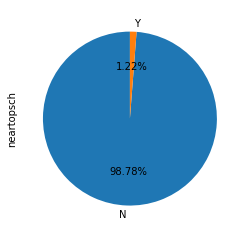

In [9]:
housing['neartopsch'].value_counts().plot.pie(autopct='%1.2f%%',startangle=90)

In [10]:
housing['neartopsch_bool'] = housing.neartopsch.map(dict(Y=1,N=0))

#### iii. storey_range
Next we look at the storey range.

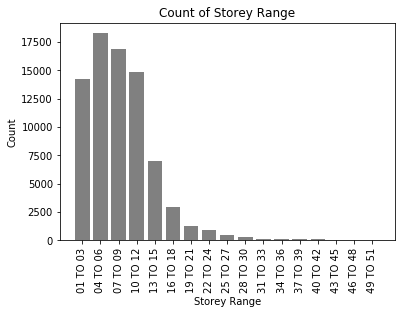

{'01 TO 03': 14200,
 '04 TO 06': 18273,
 '07 TO 09': 16906,
 '10 TO 12': 14816,
 '13 TO 15': 6969,
 '16 TO 18': 2924,
 '19 TO 21': 1275,
 '22 TO 24': 931,
 '25 TO 27': 499,
 '28 TO 30': 328,
 '31 TO 33': 143,
 '34 TO 36': 156,
 '37 TO 39': 146,
 '40 TO 42': 74,
 '43 TO 45': 12,
 '46 TO 48': 15,
 '49 TO 51': 7}

In [11]:
# Store frequency counts of each label where unique is the label and counts is its frequency
unique, counts = np.unique(housing['storey_range'], return_counts=True)

fig, ax = plt.subplots()

plt.bar(np.arange(len(housing['storey_range'].unique())), counts, color='grey')
plt.ylabel('Count')
plt.xlabel('Storey Range')
plt.title('Count of Storey Range')
plt.xticks(np.arange(len(housing['storey_range'].unique())), unique,rotation=90)
plt.show()

display(dict(zip(unique, counts)))

Storey range is the storey of the resale flat in three storey intervals. The values are ordinal in nature. Hence we extract the storey from and retain for model. No ordinal encoding is performed because we will perform scaling later anyway.

In [12]:
housing['storey_from'] = pd.to_numeric(housing['storey_range'].str.split(' TO ').str[0])

#### iv. month
Next we look at month

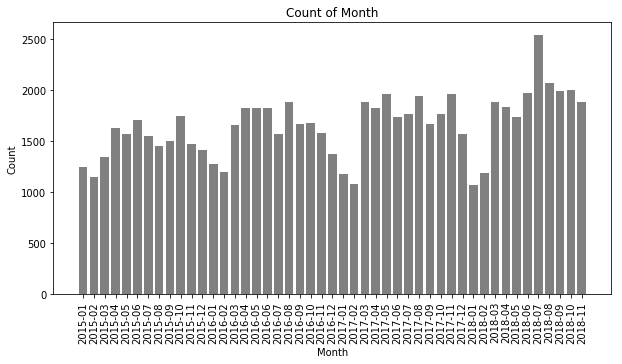

{'2015-01': 1250,
 '2015-02': 1151,
 '2015-03': 1348,
 '2015-04': 1630,
 '2015-05': 1567,
 '2015-06': 1706,
 '2015-07': 1551,
 '2015-08': 1449,
 '2015-09': 1498,
 '2015-10': 1748,
 '2015-11': 1470,
 '2015-12': 1412,
 '2016-01': 1280,
 '2016-02': 1200,
 '2016-03': 1655,
 '2016-04': 1824,
 '2016-05': 1829,
 '2016-06': 1827,
 '2016-07': 1572,
 '2016-08': 1882,
 '2016-09': 1668,
 '2016-10': 1678,
 '2016-11': 1580,
 '2016-12': 1378,
 '2017-01': 1178,
 '2017-02': 1080,
 '2017-03': 1889,
 '2017-04': 1823,
 '2017-05': 1963,
 '2017-06': 1734,
 '2017-07': 1765,
 '2017-08': 1944,
 '2017-09': 1667,
 '2017-10': 1768,
 '2017-11': 1967,
 '2017-12': 1574,
 '2018-01': 1072,
 '2018-02': 1183,
 '2018-03': 1881,
 '2018-04': 1838,
 '2018-05': 1740,
 '2018-06': 1976,
 '2018-07': 2540,
 '2018-08': 2071,
 '2018-09': 1988,
 '2018-10': 1998,
 '2018-11': 1882}

In [13]:
# Store frequency counts of each label where unique is the label and counts is its frequency
unique, counts = np.unique(housing['month'], return_counts=True)

fig, ax = plt.subplots(figsize=(10, 5))

plt.bar(np.arange(len(housing['month'].unique())), counts, color='grey')
plt.ylabel('Count')
plt.xlabel('Month')
plt.title('Count of Month')
plt.xticks(np.arange(len(housing['month'].unique())), unique,rotation=90)
plt.show()

display(dict(zip(unique, counts)))

For month, we can see that transaction volume is cyclical. There are fewer transactions in the months leading up to of chinese new year between Jan and Feb. Also, the data is stored in 'YYYY-MM' format. We will convert this to numerical period where 2015-01 is 1.

In [14]:
housing['period'] = (pd.to_numeric(housing['month'].str.split('-').str[0]) -2015)*12 + pd.to_numeric(housing['month'].str.split('-').str[1])

#### v. flat_type and flat_model
We look at the next two attributes: flat type and flat model. 

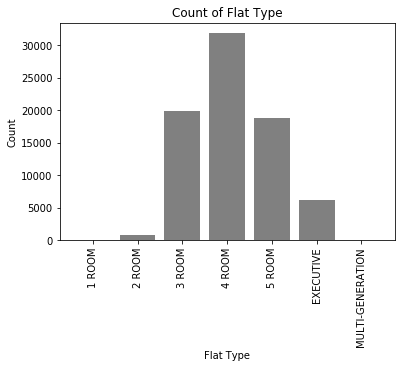

{'1 ROOM': 32,
 '2 ROOM': 835,
 '3 ROOM': 19830,
 '4 ROOM': 31878,
 '5 ROOM': 18835,
 'EXECUTIVE': 6240,
 'MULTI-GENERATION': 24}

In [15]:
# Store frequency counts of each label where unique is the label and counts is its frequency
unique, counts = np.unique(housing['flat_type'], return_counts=True)

fig, ax = plt.subplots()

plt.bar(np.arange(len(housing['flat_type'].unique())), counts, color='grey')
plt.ylabel('Count')
plt.xlabel('Flat Type')
plt.title('Count of Flat Type')
plt.xticks(np.arange(len(housing['flat_type'].unique())), unique,rotation=90)
plt.show()

display(dict(zip(unique, counts)))

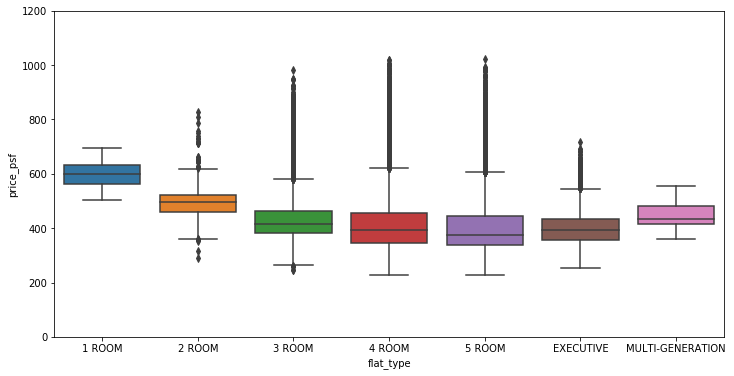

In [16]:
#box plot flat type/ price psf
import seaborn as sns
flattype_price = pd.concat([housing['price_psf'], housing['flat_type']], axis=1).sort_values(by='flat_type')
f, ax = plt.subplots(figsize=(12, 6))
fig = sns.boxplot(x='flat_type', y="price_psf", data=flattype_price)
fig.axis(ymin=0, ymax=1200);
plt.show()

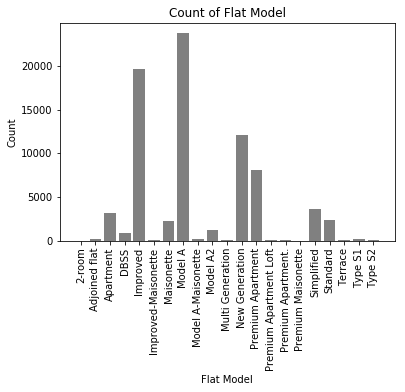

{'2-room': 1,
 'Adjoined flat': 122,
 'Apartment': 3189,
 'DBSS': 812,
 'Improved': 19657,
 'Improved-Maisonette': 15,
 'Maisonette': 2242,
 'Model A': 23709,
 'Model A-Maisonette': 131,
 'Model A2': 1187,
 'Multi Generation': 24,
 'New Generation': 12116,
 'Premium Apartment': 8113,
 'Premium Apartment Loft': 8,
 'Premium Apartment.': 59,
 'Premium Maisonette': 5,
 'Simplified': 3624,
 'Standard': 2296,
 'Terrace': 47,
 'Type S1': 216,
 'Type S2': 101}

In [17]:
# Store frequency counts of each label where unique is the label and counts is its frequency
unique, counts = np.unique(housing['flat_model'], return_counts=True)

fig, ax = plt.subplots()

plt.bar(np.arange(len(housing['flat_model'].unique())), counts, color='grey')
plt.ylabel('Count')
plt.xlabel('Flat Model')
plt.title('Count of Flat Model')
plt.xticks(np.arange(len(housing['flat_model'].unique())), unique,rotation=90)
plt.show()

display(dict(zip(unique, counts)))

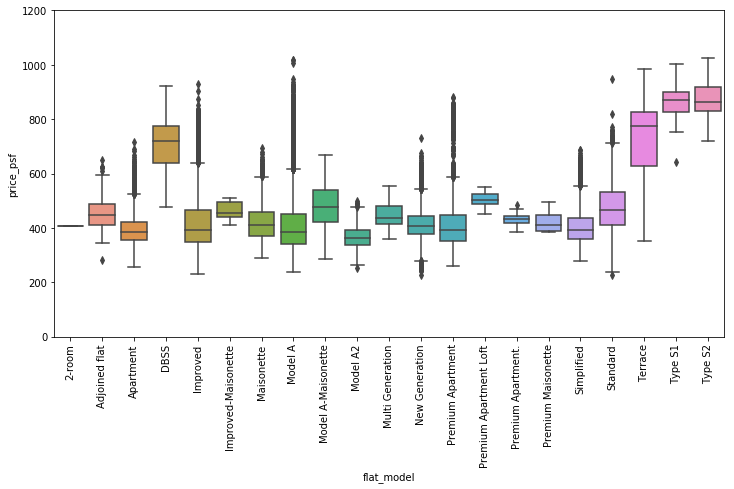

In [18]:
#box plot flat type/ price psf
import seaborn as sns
flatmodel_price = pd.concat([housing['price_psf'], housing['flat_model']], axis=1).sort_values(by='flat_model')
f, ax = plt.subplots(figsize=(12, 6))
fig = sns.boxplot(x='flat_model', y="price_psf", data=flatmodel_price)
fig.axis(ymin=0, ymax=1200);
fig.set_xticklabels(fig.get_xticklabels(),rotation=90) 
plt.show()

We note that not all flat model values have an impact on price psf, with the exception of DBSS, Terrace, Type S1 and S2. Further investigation noted that DBSS were built by private developers who were given the freedom to set prices. The first hand owners bought the units expensive and likely hence sold expensive. Terrace were essentially public landed housing. Type S1 and S2 were models specifically for units at Pinnacle @ Duxton.

It is there were two entries for Premium Apartment and Premium Apartment. (with a period). This is likely a typo, and we correct it.

In [19]:
housing['flat_model'] = housing['flat_model'].str.replace('.','')

#### vi. geometry_hdb
For the last attribute, geometry_hdb, it stores the geospatial coordinates of the resale flat and is for visualization purposes. It will also be dropped when modelling.

#### vii. Dummy Encoding
For the categorical attributes flat type, flat model, town and near station we use dummy encoding.

In [20]:
model_dummies = pd.get_dummies(housing['flat_model'])
model_dummies = model_dummies.add_prefix('model_')
housing = pd.concat([housing, model_dummies],axis=1)

In [21]:
type_dummies = pd.get_dummies(housing['flat_type'])
type_dummies = type_dummies.add_prefix('type_')
housing = pd.concat([housing, type_dummies],axis=1)

In [22]:
town_dummies = pd.get_dummies(housing['town'])
town_dummies = town_dummies.add_prefix('town_')
housing = pd.concat([housing, town_dummies],axis=1)

### 6. Exploring and Cleaning Numerical Data

Now that the categorical data has been converted to numerical we scale the numerical data to 0, 1 to facilitate modelling.

In [23]:
#view summary of numerical attributes, excluding id and dummy variables
housing.describe(include = [np.number]).iloc[:,0:15].drop('id',axis=1)

,floor_area_sqm,lease_commence_date,remaining_lease,resale_price,latitude,longitude,nearstn_dist,nearmkthwk_dist,nearprisch_dist,price_psf,floor_area_sqf,neartopsch_bool,storey_from,period
count,"77,674.0000","77,674.0000","77,674.0000","77,674.0000","77,674.0000","77,674.0000","77,674.0000","77,674.0000","77,674.0000","77,674.0000","77,674.0000","77,674.0000","77,674.0000","77,674.0000"
mean,97.6037,"1,992.0622",74.0345,"440,007.5057",1.3656,103.8391,0.7504,1.7974,0.3827,422.8695,"1,050.6058",0.0122,7.4309,25.2475
std,24.2317,11.5281,11.4991,"145,506.0480",0.0426,0.0727,0.4281,1.6293,0.2242,105.6099,260.8299,0.1098,5.6054,13.6026
min,31.0000,"1,966.0000",47.0000,"160,000.0000",1.2704,103.6852,0.0360,0.0024,0.0440,226.5909,333.6840,0.0000,1.0000,1.0000
25%,76.0000,"1,984.0000",66.0000,"338,000.0000",1.3363,103.7747,0.4431,0.3984,0.2245,353.9134,818.0640,0.0000,4.0000,14.0000
50%,96.0000,"1,992.0000",73.0000,"409,888.0000",1.3630,103.8450,0.6724,1.2940,0.3393,396.9460,"1,033.3440",0.0000,7.0000,26.0000
75%,112.0000,"2,001.0000",83.0000,"505,000.0000",1.3924,103.8990,0.9516,2.7421,0.4914,456.6383,"1,205.5680",0.0000,10.0000,37.0000
max,280.0000,"2,016.0000",97.0000,"1,185,000.0000",1.4571,103.9881,4.6535,6.1052,3.3225,"1,023.6778","3,013.9200",1.0000,49.0000,47.0000


#### i. Histogram

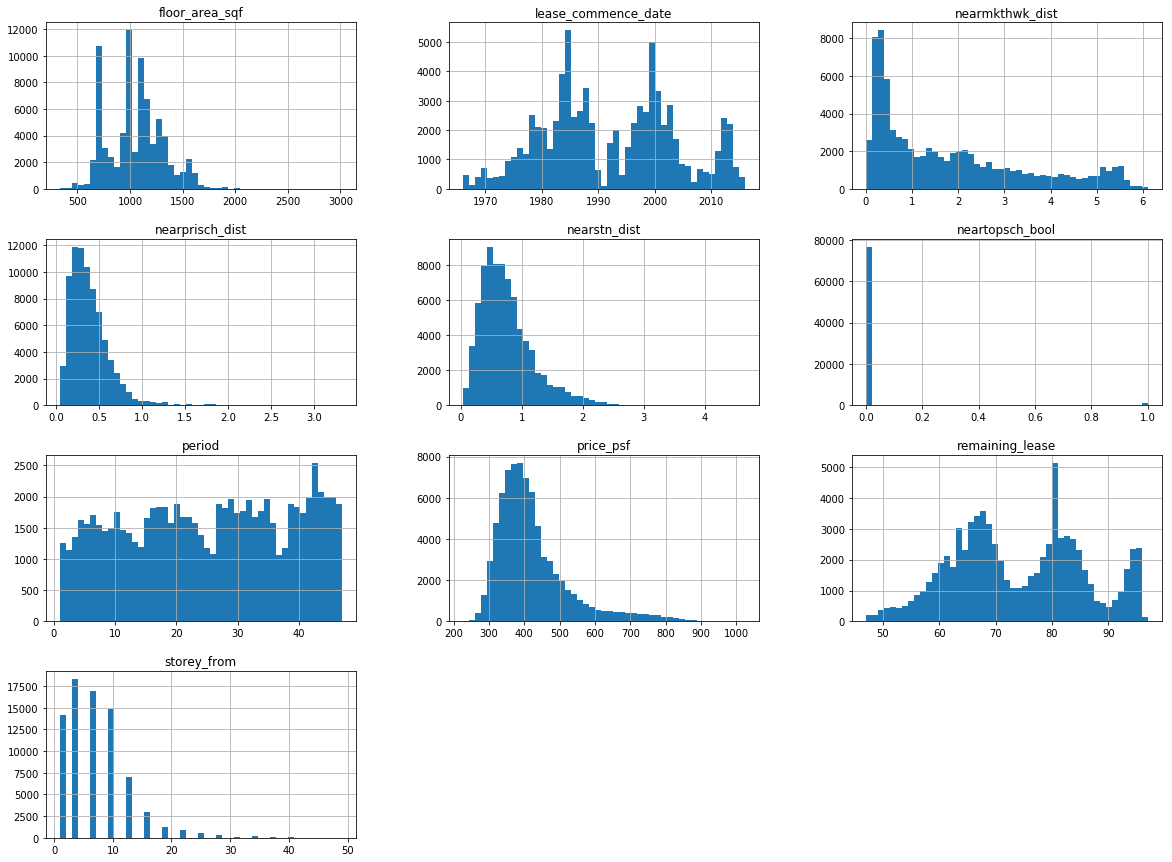

In [24]:
housing.select_dtypes(include=[np.number]).iloc[:,0:15].drop(['id', 'latitude','longitude','floor_area_sqm','resale_price'],axis=1).hist(bins=47,figsize=(20,15))
plt.show()

#### ii. Scatter Matrix

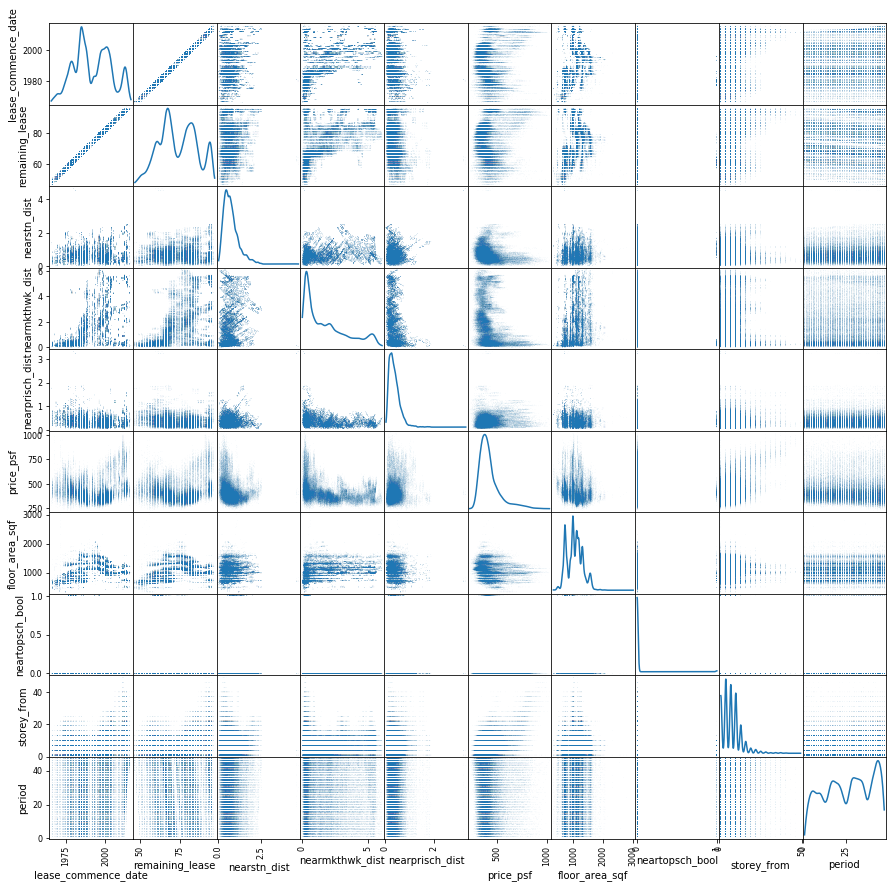

In [25]:
plt_scattermatrix = pd.plotting.scatter_matrix(
    housing.select_dtypes(include=[np.number]).iloc[:,0:15].drop([ 'id','latitude','longitude','floor_area_sqm','resale_price'],axis=1),
    figsize  = [15, 15],
    marker   = ".",
    s        = 0.2,
    diagonal = "kde"
)

From the scatter matrix, we can see that lease commence date and remaining lease is highly correlated. Consequently, the distribution of values of lease commence date and remaining lease against other attributes are also near identical. We will not require both attributes, and hence we retain only remaining lease. Remaining lease is expected to affect prices more, due to bank loan restrictions with low remaining lease.

The diagonals of the scatter matrix are density plots of the attributes. 
 * Most resale transactions appear to be between 300 to 400 price per square foot. 
 * Floor area sqf appear to be multi-modal, probably reflective of the fact that hdb sizes are of fixed ranges for 1 room, 2 room, 3 room, 4 room, 5 room, executive and multi-generation flats. See <a href="https://www.hdb.gov.sg/cs/infoweb/residential/buying-a-flat/resale/types-of-flats">Type of HDB flats</a>
 * Most resale transactions appear to be for flats within 1 km of a train station (Note: 1 km is 10 to 20 min walking time)
 * Remaining lease similarly appear to be multi-modal. This is consistent with the <a href="https://data.gov.sg/dataset/flats-constructed">number of flats constructed by HDB by year</a>. The highest number of flats constructed by HDB in a year is 67k in 1984. These flats, assuming 99-year lease, will have a remaining lease of 65 to 68  between the resale transaction year of 2015 to 2018.

#### iii. Visualizing Geospatial Data

Geospatial data can simply be plotted using longitude and latitude as x and y.

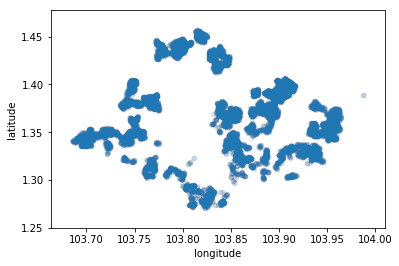

In [26]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.01)

From the above, we can see there appear to be an outlier point (incorrect coordinates?). Is it in the sea? Lets plot Singapore's map to find out.

In [27]:
import geopandas as gpd
from shapely.geometry import Point

In [28]:
housing['geometry_hdb'] = list(zip(housing.longitude, housing.latitude))
housing['geometry_hdb'] = housing['geometry_hdb'].apply(Point)
housing = gpd.GeoDataFrame(housing, geometry='geometry_hdb', crs={'init': 'epsg:4326'})

In [29]:
import os
import mpl_toolkits
from descartes import PolygonPatch
import mplleaflet

First we plot the Singapore map

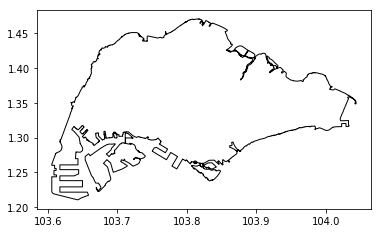

In [30]:
# https://github.com/yinshanyang/singapore/blob/master/maps/0-mainland.geojson
SGMAP_PATH = os.path.join("datasets","maps")
SGMAP_MEMBER = "0-mainland.geojson"
sgadmin = gpd.GeoDataFrame.from_file(os.path.join(SGMAP_PATH, SGMAP_MEMBER))
singapore = sgadmin.iloc[0]
gpd.GeoSeries(singapore.geometry).plot(facecolor="none", 
              edgecolor='black')

We then layer the housing dataset together with the Singapore map. And we can see that the coordinates are within the map. In fact, these flats belong to changi village.

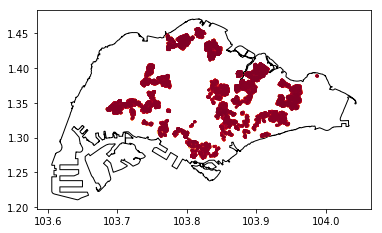

In [31]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
sgadmin.plot(ax=ax, facecolor="none", 
              edgecolor='black')
housing.geometry_hdb.plot(ax=ax, marker='o', markersize=3,cmap='YlOrRd')
plt.show();

Add further detail using planning areas

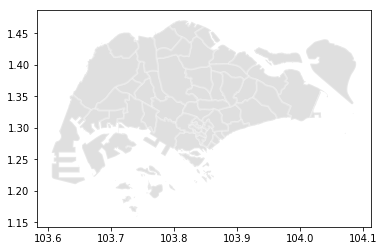

In [32]:
SGPA_MEMBER = "MP14_PLNG_AREA_WEB_PL.shp"
sgpa = gpd.read_file(os.path.join(SGMAP_PATH, SGPA_MEMBER))
sgpa.crs = {'init':'epsg:3414'}
sgpa = sgpa.to_crs({'init':'epsg:4326'})
sgpa.plot(facecolor="grey", 
              edgecolor='white',alpha=0.25,linewidth=2)

We then combine all three layers

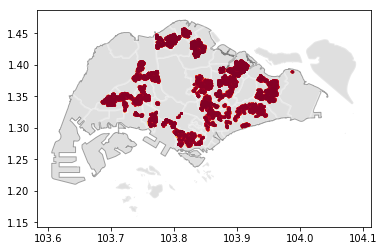

In [33]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
sgadmin.plot(ax=ax, facecolor="none", 
              edgecolor='grey')
sgpa.geometry.plot(ax=ax,facecolor="grey", 
              edgecolor='white',alpha=0.25,linewidth=2)
housing.geometry_hdb.plot(ax=ax, marker='o', markersize=3,cmap='YlOrRd')
plt.show();

Rather than see red dots, we plot median housing prices like a heat map over the points.

In [34]:
median_psf = housing.groupby(by='town')['price_psf'].median()
median_psf = median_psf.to_frame().reset_index()

In [35]:
housing_median= housing.merge(median_psf,on='town',how='left',suffixes=['_trx','_median'])

We first plot price psf 

/Users/alphaniang/anaconda3/lib/python3.6/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)


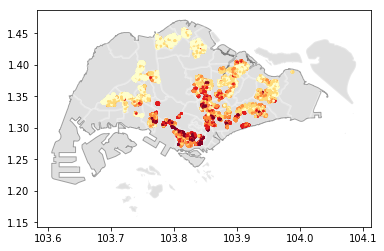

In [36]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
sgadmin.plot(ax=ax, facecolor="none", 
              edgecolor='grey')
sgpa.geometry.plot(ax=ax,facecolor="grey", 
              edgecolor='white',alpha=0.25,linewidth=2)
housing_median.plot(ax=ax, marker='o', markersize=3,cmap='YlOrRd',column='price_psf_trx',scheme='fisher_jenks')
plt.show();

We also can plot by each town's median price psf 

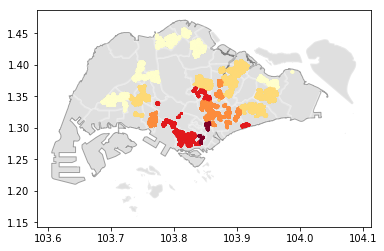

In [37]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
sgadmin.plot(ax=ax, facecolor="none", 
              edgecolor='grey')
sgpa.geometry.plot(ax=ax,facecolor="grey", 
              edgecolor='white',alpha=0.25,linewidth=2)
housing_median.plot(ax=ax, marker='o',       markersize=3,cmap='YlOrRd',column='price_psf_median',scheme='fisher_jenks')
plt.show();

Plotting by median prices, we can clearly compare the prices between towns. In general the central area commands higher prices. Prices fall as the resale flats gets nearer to the boundaries of Singapore. With the exception of Bishan (approx center of the Singapore map), where transaction prices are higher than Toa Payoh, Kallang and Geylang even though these other towns are nearer to the center.

#### iv. Correlation Matrix

Not all the columns in the dataset will be used for modelling. Reasons for dropping the columns are detailed above. We plot the correlation matrix on the data we intend to use for modelling

In [38]:
list(housing)

['month',
 'town',
 'flat_type',
 'block',
 'street_name',
 'storey_range',
 'floor_area_sqm',
 'flat_model',
 'lease_commence_date',
 'remaining_lease',
 'resale_price',
 'geometry_hdb',
 'latitude',
 'longitude',
 'nearstn_dist',
 'nearmkthwk_dist',
 'nearprisch_dist',
 'neartopsch',
 'id',
 'price_psf',
 'floor_area_sqf',
 'neartopsch_bool',
 'storey_from',
 'period',
 'model_2-room',
 'model_Adjoined flat',
 'model_Apartment',
 'model_DBSS',
 'model_Improved',
 'model_Improved-Maisonette',
 'model_Maisonette',
 'model_Model A',
 'model_Model A-Maisonette',
 'model_Model A2',
 'model_Multi Generation',
 'model_New Generation',
 'model_Premium Apartment',
 'model_Premium Apartment Loft',
 'model_Premium Maisonette',
 'model_Simplified',
 'model_Standard',
 'model_Terrace',
 'model_Type S1',
 'model_Type S2',
 'type_1 ROOM',
 'type_2 ROOM',
 'type_3 ROOM',
 'type_4 ROOM',
 'type_5 ROOM',
 'type_EXECUTIVE',
 'type_MULTI-GENERATION',
 'town_ANG MO KIO',
 'town_BEDOK',
 'town_BISHAN',
 '

In [39]:
col_drop_wid =['id','latitude','longitude','geometry_hdb','month','resale_price','neartopsch','lease_commence_date','storey_range','floor_area_sqm','town','flat_type','flat_model','block','street_name']

In [40]:
col_drop =['latitude','longitude','geometry_hdb','month','resale_price','neartopsch','lease_commence_date','storey_range','floor_area_sqm','town','flat_type','flat_model','block','street_name']

In [41]:
corr_matrix = housing.drop(col_drop_wid,axis=1).corr()

Based on the correlation matrix below,the matrix is mostly white/ light coloured. Hence, the model do not suffer (greatly) from collinearity.

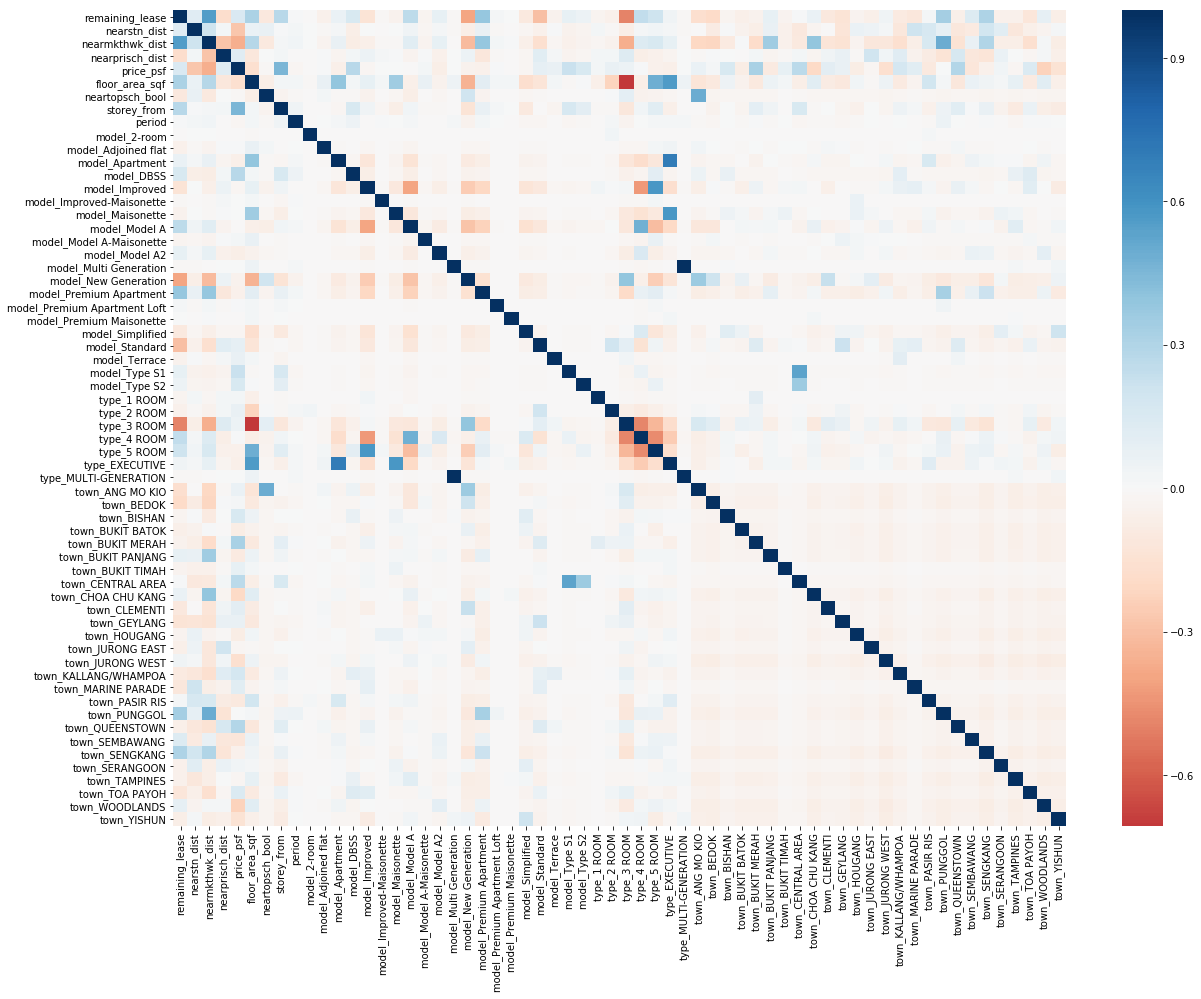

In [42]:
plt.subplots(figsize=(20,15))
sns.heatmap(corr_matrix, cmap="RdBu",center=0,
            xticklabels=corr_matrix.columns.values,
            yticklabels=corr_matrix.columns.values)

We also look at the top 10 / bottom features most correlated with price psf.

In [43]:
display(corr_matrix["price_psf"].sort_values(ascending=False).head(10))

price_psf              1.0000
storey_from            0.4598
town_BUKIT MERAH       0.3220
town_QUEENSTOWN        0.2903
model_DBSS             0.2779
town_CENTRAL AREA      0.2736
model_Type S1          0.2228
town_KALLANG/WHAMPOA   0.1772
town_BISHAN            0.1669
model_Type S2          0.1541
Name: price_psf, dtype: float64

In [44]:
display(corr_matrix["price_psf"].sort_values(ascending=False).tail(10))

town_BUKIT PANJANG   -0.0912
town_PASIR RIS       -0.0992
town_SEMBAWANG       -0.1194
town_YISHUN          -0.1420
floor_area_sqf       -0.1547
town_JURONG WEST     -0.1580
town_CHOA CHU KANG   -0.1936
town_WOODLANDS       -0.2279
nearstn_dist         -0.2729
nearmkthwk_dist      -0.3620
Name: price_psf, dtype: float64

### 7. Split train test set

To recap, data transformation (e.g. dummy encoding) has already been performed. Columns which are not numerical is not necessary for modelling.

In [45]:
#quick look at the data which would be used for modelling
housing.drop(col_drop_wid, axis=1).select_dtypes(include = [np.number]).describe()

,remaining_lease,nearstn_dist,nearmkthwk_dist,nearprisch_dist,price_psf,floor_area_sqf,neartopsch_bool,storey_from,period,model_2-room,...,town_PASIR RIS,town_PUNGGOL,town_QUEENSTOWN,town_SEMBAWANG,town_SENGKANG,town_SERANGOON,town_TAMPINES,town_TOA PAYOH,town_WOODLANDS,town_YISHUN
count,"77,674.0000","77,674.0000","77,674.0000","77,674.0000","77,674.0000","77,674.0000","77,674.0000","77,674.0000","77,674.0000","77,674.0000",...,"77,674.0000","77,674.0000","77,674.0000","77,674.0000","77,674.0000","77,674.0000","77,674.0000","77,674.0000","77,674.0000","77,674.0000"
mean,74.0345,0.7504,1.7974,0.3827,422.8695,"1,050.6058",0.0122,7.4309,25.2475,0.0000,...,0.0308,0.0551,0.0268,0.0267,0.0730,0.0217,0.0674,0.0327,0.0729,0.0592
std,11.4991,0.4281,1.6293,0.2242,105.6099,260.8299,0.1098,5.6054,13.6026,0.0036,...,0.1727,0.2282,0.1614,0.1611,0.2602,0.1456,0.2508,0.1778,0.2600,0.2361
min,47.0000,0.0360,0.0024,0.0440,226.5909,333.6840,0.0000,1.0000,1.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,66.0000,0.4431,0.3984,0.2245,353.9134,818.0640,0.0000,4.0000,14.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,73.0000,0.6724,1.2940,0.3393,396.9460,"1,033.3440",0.0000,7.0000,26.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
75%,83.0000,0.9516,2.7421,0.4914,456.6383,"1,205.5680",0.0000,10.0000,37.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
max,97.0000,4.6535,6.1052,3.3225,"1,023.6778","3,013.9200",1.0000,49.0000,47.0000,1.0000,...,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


We separate the features from the label. Note: the id column is just a failsafe to ensure that we can correctly map the features to the correct label in case the index column is shuffled.

In [46]:
housing_X = housing.drop(col_drop, axis=1).select_dtypes(include = [np.number]).drop('price_psf',axis=1) # drop labels for training/ test X values
housing_y = housing[["id","price_psf"]].copy()

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(housing_X, housing_y, test_size=0.20, random_state=seedno)

Due to shuffling, the index columns are now jumbled due to the train test split. Hence we reset the index, in view that we already created an id column from before we dont have to worry about data integrity should we mess up the sorting order.

In [48]:
X_train.reset_index(inplace=True,drop=True)
y_train.reset_index(inplace=True,drop=True)
X_test.reset_index(inplace=True,drop=True)
y_test.reset_index(inplace=True,drop=True)

Now that we have split the training and test dataset, we standardize the numerical values which are not in 0 to 1 range. For columns already in 0 (e.g. dummy variables), 1 form we will not further standardization. Standardization is only performed after splitting the dataset in order to avoid contamination of data between the training and test dataset. 

In [49]:
numericals = ['remaining_lease','nearstn_dist','nearmkthwk_dist','nearprisch_dist','floor_area_sqf','neartopsch_bool','storey_from','period']

In [50]:
from sklearn.preprocessing import StandardScaler
numericals_scale = StandardScaler().fit(X_train[numericals])

In [51]:
X_train_scaled = numericals_scale.transform(X_train[numericals])

We check on the data before and after scaling to verify

In [52]:
X_train[numericals].describe()

,remaining_lease,nearstn_dist,nearmkthwk_dist,nearprisch_dist,floor_area_sqf,neartopsch_bool,storey_from,period
count,"62,139.0000","62,139.0000","62,139.0000","62,139.0000","62,139.0000","62,139.0000","62,139.0000","62,139.0000"
mean,74.0413,0.7506,1.8014,0.3830,"1,050.8711",0.0123,7.4263,25.2725
std,11.5011,0.4271,1.6323,0.2241,260.4230,0.1102,5.5873,13.5907
min,47.0000,0.0360,0.0024,0.0440,333.6840,0.0000,1.0000,1.0000
25%,66.0000,0.4436,0.3984,0.2245,828.8280,0.0000,4.0000,14.0000
50%,73.0000,0.6719,1.2963,0.3395,"1,033.3440",0.0000,7.0000,26.0000
75%,83.0000,0.9514,2.7604,0.4916,"1,205.5680",0.0000,10.0000,37.0000
max,97.0000,4.6535,6.1052,3.3225,"3,013.9200",1.0000,49.0000,47.0000


In [53]:
pd.DataFrame(X_train_scaled).describe()

,0,1,2,3,4,5,6,7
count,"62,139.0000","62,139.0000","62,139.0000","62,139.0000","62,139.0000","62,139.0000","62,139.0000","62,139.0000"
mean,0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.0000
std,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
min,-2.3512,-1.6731,-1.1022,-1.5127,-2.7540,-0.1116,-1.1502,-1.7860
25%,-0.6992,-0.7189,-0.8596,-0.7072,-0.8526,-0.1116,-0.6132,-0.8294
50%,-0.0905,-0.1841,-0.3095,-0.1941,-0.0673,-0.1116,-0.0763,0.0535
75%,0.7790,0.4702,0.5875,0.4843,0.5940,-0.1116,0.4606,0.8629
max,1.9962,9.1387,2.6367,13.1158,7.5380,8.9629,7.4408,1.5987


Once we verify that all is in order, we drop the original numerical values and replace them with the scaled ones.

In [54]:
X_train = pd.concat([X_train.drop(numericals,axis=1), pd.DataFrame(X_train_scaled,columns=numericals)],axis=1)

In [55]:
X_train.shape

(62139, 62)

We also transform the test dataset. Note that we only perform transform on the test dataset and fit transform on the training set. 

In [56]:
X_test_scaled = numericals_scale.transform(X_test[numericals])

In [57]:
X_test = pd.concat([X_test.drop(numericals,axis=1), pd.DataFrame(X_test_scaled,columns=numericals)],axis=1)

In [58]:
X_test.shape

(15535, 62)

### Part 3: Predicting Prices

### 1. Review of Performance Different Models

After the tedious process of reviewing and preparing the data, its time to predict prices! For large datasets, we may not have computational resources to look at the performance of all models, but our dataset size is reasonable. We run 10 models to review the performance of each.

In [59]:
# Import statements of models 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
import time

In [60]:
# Append statements of models 
models = []
models.append(('LR', LinearRegression()))
models.append(('LS', Lasso(random_state=seedno)))
models.append(('RD', Ridge(random_state=seedno)))
models.append(('EN', ElasticNet(random_state=seedno)))
models.append(('DTR', DecisionTreeRegressor(random_state=seedno)))
models.append(('KNR', KNeighborsRegressor()))
models.append(('SVR', SVR()))
models.append(('SGD', SGDRegressor(random_state=seedno)))
models.append(('RFR', RandomForestRegressor(random_state=seedno)))
models.append(('GBR', GradientBoostingRegressor(random_state=seedno)))
models.append(('ABR', AdaBoostRegressor(random_state=seedno)))
models.append(('MLP', MLPRegressor(random_state=seedno)))

In [61]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [62]:
names = []
scores = []
runtimes = []

for name, model in models:
    starttime=time.time()
    model.fit(X_train.drop('id',axis=1), y_train['price_psf'])
    y_pred = model.predict(X_test.drop('id',axis=1))
    scores.append(mean_squared_error(y_test['price_psf'], y_pred))
    names.append(name)
    runtimes.append(time.time()-starttime)

/Users/alphaniang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Users/alphaniang/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [63]:
model_results = pd.DataFrame({"Model": names,"RMSE": np.sqrt(scores),"Runtime": runtimes}).sort_values(by='RMSE',ascending=True).reset_index(drop=True)
display(model_results)

,Model,RMSE,Runtime
0,RFR,25.3839,7.0593
1,MLP,27.2156,65.0443
2,KNR,27.6402,18.5134
3,DTR,33.9436,1.0264
4,GBR,38.4453,13.7975
5,RD,40.8817,0.0874
6,LR,40.8979,0.2829
7,SGD,43.3352,0.2458
8,LS,52.3505,0.2191
9,SVR,52.5773,604.0345


### 2. Selecting the Model

From the results, Random Forest Regressor performed the best. We use Random Forest to perform further refinements to see if we can improve its performance

In [64]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [65]:
def display_scores(scores):
    display(pd.DataFrame({"Scores": scores}))
    display("Mean:", scores.mean())
    display("Standard Deviation:", scores.std())

We first look at the model parameters in a normal run.

In [66]:
rfr = RandomForestRegressor(random_state=seedno)
rfr.fit(X_train.drop('id',axis=1), y_train['price_psf'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=18704, verbose=0,
           warm_start=False)

In [67]:
y_pred = rfr.predict(X_test.drop('id',axis=1))

In [68]:
rfr_score = np.sqrt(mean_squared_error(y_test['price_psf'], y_pred))
display(rfr_score)

25.383873012648465

In [69]:
scores = cross_val_score(estimator=rfr, X=X_train.drop('id',axis=1), y=y_train['price_psf'],scoring="neg_mean_squared_error", cv=10)
rfr_rmse = np.sqrt(-scores)

In [70]:
display_scores(rfr_rmse)

,Scores
0,25.4938
1,25.6025
2,25.4473
3,25.9255
4,25.3744
5,26.1830
6,25.7159
7,26.1475
8,25.5308
9,25.7472


'Mean:'

25.716770824547876

'Standard Deviation:'

0.2710286142256576

We perform grid search to find if we can tweak the model parameters to improve performance.

In [71]:
from sklearn.model_selection import GridSearchCV

rfr_param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

rfr = RandomForestRegressor() 
grid_search = GridSearchCV(rfr, rfr_param_grid, cv=10,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train.drop('id',axis=1), y_train['price_psf'])

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

The best hyperparameter combination found:

In [72]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [73]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

Let's look at the score of each hyperparameter combination tested during the grid search:

In [74]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

31.52290079745584 {'max_features': 2, 'n_estimators': 3}
26.888347075949127 {'max_features': 2, 'n_estimators': 10}
25.204720309150645 {'max_features': 2, 'n_estimators': 30}
30.667115967671343 {'max_features': 4, 'n_estimators': 3}
26.300871355004936 {'max_features': 4, 'n_estimators': 10}
24.828429555922394 {'max_features': 4, 'n_estimators': 30}
30.387541791831353 {'max_features': 6, 'n_estimators': 3}
25.97778272313129 {'max_features': 6, 'n_estimators': 10}
24.64428135403731 {'max_features': 6, 'n_estimators': 30}
29.879815388383626 {'max_features': 8, 'n_estimators': 3}
25.728400792905042 {'max_features': 8, 'n_estimators': 10}
24.4270022380959 {'max_features': 8, 'n_estimators': 30}
29.95145139846661 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
26.2781454824043 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
30.09278236559716 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
26.098577041265116 {'bootstrap': False, 'max_features': 3, 'n_estimato

We try using randomized seach cv to see if the performance can be improved.

In [75]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

rfr_distr = {
        'n_estimators': randint(low=1, high=50),
        'max_features': randint(low=1, high=10),
    }

rfr = RandomForestRegressor(random_state=seedno)
rnd_search = RandomizedSearchCV(rfr, param_distributions=rfr_distr,random_state=seedno,
                                n_iter=10, cv=10, scoring='neg_mean_squared_error')
rnd_search.fit(X_train.drop('id',axis=1), y_train['price_psf'])

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=18704, verbose=0,
           warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a3e3c6dd8>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a3e3c64e0>},
          pre_dispatch='2*n_jobs', random_state=18704, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [76]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

24.76654235321138 {'max_features': 4, 'n_estimators': 31}
25.045409782369788 {'max_features': 6, 'n_estimators': 19}
25.01950451481831 {'max_features': 1, 'n_estimators': 45}
25.08568288979816 {'max_features': 1, 'n_estimators': 39}
25.289417628127314 {'max_features': 4, 'n_estimators': 18}
24.535614349971677 {'max_features': 8, 'n_estimators': 26}
24.588117097639646 {'max_features': 6, 'n_estimators': 31}
24.807173866125737 {'max_features': 3, 'n_estimators': 44}
24.733765782828378 {'max_features': 6, 'n_estimators': 26}
25.12393971732394 {'max_features': 5, 'n_estimators': 18}


Results are fairly similar, we will stick to grid search!

### 3. Feature Selection

Random forest comes with inbuilt feature importances. Let us view them.

In [77]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([1.34609301e-06, 1.32288141e-04, 5.95710300e-04, 3.61715443e-02,
       6.08850282e-03, 4.17995563e-05, 8.11619231e-04, 1.61304448e-02,
       1.92285509e-04, 2.46071191e-04, 3.57225843e-05, 6.24749314e-03,
       5.89580065e-03, 1.26605524e-05, 1.75684979e-06, 1.21585413e-03,
       3.18903590e-03, 2.68817140e-03, 1.40528640e-02, 3.09551592e-03,
       1.46604874e-04, 1.94730527e-03, 9.38108816e-03, 6.44174225e-03,
       4.50071543e-03, 2.29441835e-03, 3.58098262e-05, 3.83253707e-03,
       4.45215343e-03, 1.90819577e-02, 3.03796554e-03, 5.82194116e-02,
       2.22859874e-03, 3.45460210e-03, 2.72017489e-02, 1.22214364e-02,
       5.86144141e-03, 2.81327126e-03, 2.36639506e-03, 2.98022641e-03,
       1.70864805e-02, 1.05918834e-02, 7.84224180e-03, 8.17714827e-04,
       2.55259458e-03, 4.03915001e-02, 4.44906378e-03, 2.60841170e-03,
       5.81520403e-03, 4.80314525e-03, 7.97440982e-03, 2.45329003e-02,
       8.65965471e-03, 1.29825720e-01, 1.05217736e-01, 1.47275245e-01,
      

Let us have a look at the top 10 features important to predicting prices!

In [78]:
pd.DataFrame({'Feature':list(X_train.drop('id',axis=1)), 'Importance':feature_importances}).sort_values(by='Importance',ascending=False).reset_index(drop=True).head(10)

,Feature,Importance
0,nearmkthwk_dist,0.1473
1,remaining_lease,0.1298
2,nearstn_dist,0.1052
3,storey_from,0.1001
4,town_BUKIT MERAH,0.0582
5,floor_area_sqf,0.0516
6,town_QUEENSTOWN,0.0404
7,model_DBSS,0.0362
8,nearprisch_dist,0.0358
9,town_CENTRAL AREA,0.0272


In [79]:
from sklearn.feature_selection import RFECV
rfecv = RFECV(estimator=rfr,step=1,cv=10,scoring='neg_mean_squared_error')
rfecv.fit(X_train.drop('id',axis=1), y_train['price_psf'])

RFECV(cv=10,
   estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=18704, verbose=0,
           warm_start=False),
   n_jobs=1, scoring='neg_mean_squared_error', step=1, verbose=0)

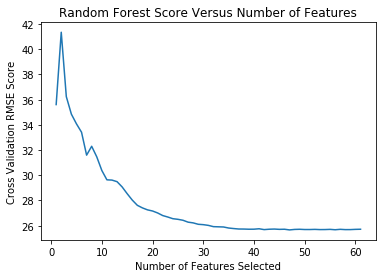

In [80]:
rfecv_rmse=np.sqrt(-1*rfecv.grid_scores_)
plt.figure()
plt.title('Random Forest Score Versus Number of Features')
plt.xlabel('Number of Features Selected')
plt.ylabel('Cross Validation RMSE Score')
plt.plot(range(1,len(rfecv.grid_scores_)+1),rfecv_rmse)
plt.show()

In [81]:
rfecv_features=list(zip(list(X_train.drop('id',axis=1)),rfecv.support_))
new_features=[]
for key,value in enumerate(rfecv_features):
    if (value[1])==True:
        new_features.append(value[0])
print(new_features)

['model_Apartment', 'model_DBSS', 'model_Improved', 'model_Maisonette', 'model_Model A', 'model_New Generation', 'model_Premium Apartment', 'model_Simplified', 'model_Standard', 'model_Terrace', 'model_Type S1', 'type_2 ROOM', 'type_3 ROOM', 'type_4 ROOM', 'type_5 ROOM', 'type_EXECUTIVE', 'town_ANG MO KIO', 'town_BEDOK', 'town_BISHAN', 'town_BUKIT BATOK', 'town_BUKIT MERAH', 'town_BUKIT PANJANG', 'town_BUKIT TIMAH', 'town_CENTRAL AREA', 'town_CHOA CHU KANG', 'town_CLEMENTI', 'town_GEYLANG', 'town_HOUGANG', 'town_JURONG EAST', 'town_JURONG WEST', 'town_KALLANG/WHAMPOA', 'town_MARINE PARADE', 'town_QUEENSTOWN', 'town_SEMBAWANG', 'town_SENGKANG', 'town_SERANGOON', 'town_TAMPINES', 'town_TOA PAYOH', 'town_WOODLANDS', 'town_YISHUN', 'remaining_lease', 'nearstn_dist', 'nearmkthwk_dist', 'nearprisch_dist', 'floor_area_sqf', 'storey_from', 'period']


Compare scores with cross validation!

In [82]:
rfr=RandomForestRegressor(random_state=seedno)
gs_rfr=RandomForestRegressor(**grid_search.best_params_,random_state=seedno)
rfecv_X_train =X_train[new_features]

initial_score=cross_val_score(rfr,X=X_train.drop('id',axis=1), y=y_train['price_psf'],cv=10,scoring='neg_mean_squared_error').mean()
print('Initial RMSE: {}'.format(np.sqrt(-1*initial_score)))
      
gridsearch_score=cross_val_score(gs_rfr,X=X_train.drop('id',axis=1), y=y_train['price_psf'],cv=10,scoring='neg_mean_squared_error').mean()
print('Grid Search Best RMSE: {}'.format(np.sqrt(-1*gridsearch_score)))
      
rfecv_score=cross_val_score(rfr,X=rfecv_X_train, y=y_train['price_psf'],cv=10,scoring='neg_mean_squared_error').mean()
print('RFECV RMSE: {}'.format(np.sqrt(-1*rfecv_score)))
      
gs_rfecv_score=cross_val_score(gs_rfr,X=rfecv_X_train, y=y_train['price_psf'],cv=10,scoring='neg_mean_squared_error').mean()
print('RFECV GS RMSE: {}'.format(np.sqrt(-1*gs_rfecv_score)))

Initial RMSE: 25.71819896789132
Grid Search Best RMSE: 24.409912359251432
RFECV RMSE: 25.68668906050656
RFECV GS RMSE: 24.25304250833729


Interestingly using the subset of features as defined by RFECV produced worse results than the initial. But with the optimized parameters from the gridsearch, we were able to produce a RMSE of 24.2psf. In conclusion, this is appear to be a very good model!

Lets see its performance on unseen data

In [83]:
gs_rfr.fit(X_train.drop('id',axis=1), y_train['price_psf'])
y_pred = gs_rfr.predict(X_test.drop('id',axis=1))
gs_rfr_score = np.sqrt(mean_squared_error(y_test['price_psf'], y_pred))
display(gs_rfr_score)

24.377252547658486

We started with 25.38psf RMSE, and improved our score to 24.37psf. Great!

In [85]:
#timing may not be accurate as it takes absolute start and end times. Apparently the code may not be running if computer is 'sleeping' (at least on my mac)
print('Thanks for spending your time on this code! Total time taken (in mins):')
display((time.time()-nbstarttime)/60)

Thanks for spending your time on this code! Total time taken (in mins):


295.9804235657056

The End!